# Meshgrid 

Meshgrid is an incredibly useful, but conceptually somewhat challenging function to learn. If you think you're alone in being confused by how or when to use it [you're not.](https://stackoverflow.com/questions/36013063/what-is-the-purpose-of-meshgrid-in-python-numpy) That question on StackOverflow has over 240,000 views, and is only one of hundreds asking about meshgrid. 

That said, it is a tool that *very often* saves us the use of a loop *as a direct outcome* of its use. Thus, when we want to write simple, efficient, and fast(er) code, it can be the cure to many bottlenecks. 

In this Quick Tip, I will attempt to elucidate the use of this function using the example of finding the centroid (in $x$ and $y$) of a 2 dimensional image. 

## The Setup 

Let's say I have a 2D image that contains a star. We have some "nominal" position for the star, namely, the pixel (x,y) that contains the most flux (we probably found the star by looking for peaks). 

Our star, for which I'll assert the peak coordinates are (326, 312) looks something like this:

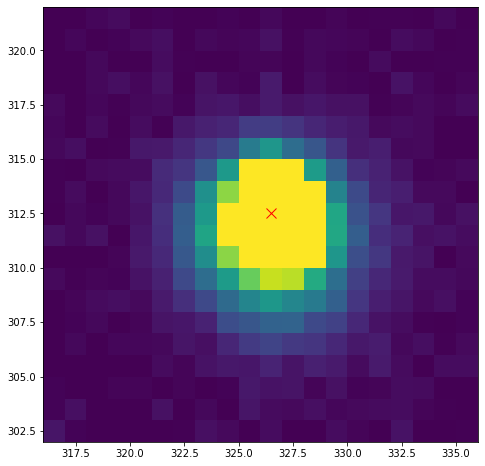

In [15]:
import numpy as np
import matplotlib.pyplot as plt
im = np.load('cutout.npy')
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(im,origin='lower',extent=[316,336,302,322],vmin=0,vmax=7000)
ax.plot(326.5,312.5,'rx',ms=10);

Where I've loaded in a cutout, and marked the pixel marked as the peak. We're going to calculate the centroid (center of light) using the formulas 

$$
x_{\rm com} = \frac{\sum x_i \hat{f}_i}{\sum\hat{f}_i}
$$

$$
y_{\rm com} = \frac{\sum y_i \hat{f}_i}{\sum\hat{f}_i}
$$

Our initial inclination, seeing sums, is to write a for-loop that looks like this:

In [17]:
total_flux = 0
x_numerator = 0
y_numerator = 0
for i in np.arange(im.shape[0]): #these are the y values
    for j in np.arange(im.shape[1]): #these are the x values
        actual_x = j + 316
        actual_y = i + 302
        total_flux += im[i,j]
        x_numerator += im[i,j]*actual_x
        y_numerator += im[i,j]*actual_y
x_com = x_numerator / total_flux
y_com = y_numerator / total_flux

In [18]:
print(x_com,y_com)

326.1555217344145 311.375121173322


The above solution works. For each pixel in the image (fully looping), we first determine the x or y value at that location (adding the actual left and bottom location to our indexing), then perform the multiplication of $\hat{f}_ix_i$ and add it to our running sums outside. 

The issue with this solution is it is very slow to loop over every pixel... especially *when we don't have to!* 

## Using Meshgrid Instead 

For a solution to these formulas to not require any looping, we need to be able to muliply our entire cutout image by another array of the same shape. So what we need is, in the case of $x$, an array that contains as its values the x coordinate at that location. That means that each column of this array will contain a single number. For $y$ we want the opposite; we want the pixels in each row to contain the y value of that row (so each row is all the same number). 

Notice that if we had arrays that look like this, when we muliply the full array, `im` by one of these arrays, we'll get an array of the same shape with the pixel by pixel multiplication between the two. For example:

In [19]:
a = np.array([[1,2,3],
              [4,5,6],
              [7,8,9]])

b = np.array([[1,2,3],
              [1,2,3],
              [1,2,3]])              
c = np.array([[1,1,1],
              [2,2,2],
              [3,3,3]]) 

ab = a*b 
ac = a*c

In [20]:
ab

array([[ 1,  4,  9],
       [ 4, 10, 18],
       [ 7, 16, 27]])

In [21]:
ac

array([[ 1,  2,  3],
       [ 8, 10, 12],
       [21, 24, 27]])

Notice that in the above example, if `a` were my fluxes, then `b` and `c`, when multiplied by `a`, produce outputs that look like $\hat{f}_i x_i$ and $\hat{f}_i y_i$. Meaning to carry out the *sum* indicated in the formulas, we can simply

In [22]:
np.sum(ab)

96

In [23]:
np.sum(ac)

108

And thus, our formula reduces to a single line:

In [24]:
a_comx = np.sum(a*b)/np.sum(a)
a_comy = np.sum(a*c)/np.sum(a)

Once you understand what's happening above, we can move into the application to our actual image. 

Because I have a cutout already (rather than a full image), I don't need to index `image` below. But if you had a full image, you'd index it over the same ranged defined in the `x_range` and `y_range` below.

In [26]:
def centroid(image,peak_x,peak_y,N):
    '''
    Return the x and y centroid of an input image, calculated within some window.
    
    Parameters
    ----------
    image: array_like
        image to be centroided. 
    peak_x: int
        x coordinate of pixel containing the peak flux. Used as a central point to define the window
    peak_y: int
        y coordinate of pixel containing the peak flux. Used as a central point to define the window
    N: int
        window size. The centroid will be calculated in a region +/- N pixels about the peak pixel
    '''
    x_range = np.arange(peak_x-N,peak_x+N)
    y_range = np.arange(peak_y-N,peak_y+N)
    

    xx, yy = np.meshgrid(x_range,y_range) # This is the key line. We now have 2D arrays, size 2N by 2N, where each column of xx has the x value, and row of yy has the y value. 
    
    x_com = np.sum(image*xx)/np.sum(image)
    y_com = np.sum(image*yy)/np.sum(image)
    return x_com, y_com

In [39]:
x_com, y_com = centroid(im,326,312,N=10)
print(x_com,y_com)

326.15552173441495 311.3751211733219


Notice that we get precisely the same answer as before. However, I can promise that the second solution will scale much more elegantly with large numbers of images or large numbers of pixels. 

Let's time it:

In [28]:
%%timeit 

centroid(im,326,312,N=10)

50 µs ± 2.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [29]:
def centroid_looping(im):
    total_flux = 0
    x_numerator = 0
    y_numerator = 0
    for i in np.arange(im.shape[0]): #these are the y values
        for j in np.arange(im.shape[1]): #these are the x values
            actual_x = j + 316
            actual_y = i + 302
            total_flux += im[i,j]
            x_numerator += im[i,j]*actual_x
            y_numerator += im[i,j]*actual_y
    x_com = x_numerator / total_flux
    y_com = y_numerator / total_flux
    return x_com, y_com

In [30]:
%%timeit 

centroid_looping(im)

439 µs ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [31]:
439/50

8.78

Even on a cutout this small, the vectorized solution is a factor of ~9 faster. In a case where we have a big enough image or set of images to where the vector-centroid pipeline takes an hour to run, the other solution would take all day!

To elucidate explicitly what we created, let's actually print our meshgrid. To save space, I'm going to only show the first 10 columns and rows for each.

In [32]:
peak_x = 326
peak_y = 312
N=10
x_range = np.arange(peak_x-N,peak_x+N)
y_range = np.arange(peak_y-N,peak_y+N)

xx, yy = np.meshgrid(x_range,y_range)

In [37]:
xx[:10,:10]

array([[316, 317, 318, 319, 320, 321, 322, 323, 324, 325],
       [316, 317, 318, 319, 320, 321, 322, 323, 324, 325],
       [316, 317, 318, 319, 320, 321, 322, 323, 324, 325],
       [316, 317, 318, 319, 320, 321, 322, 323, 324, 325],
       [316, 317, 318, 319, 320, 321, 322, 323, 324, 325],
       [316, 317, 318, 319, 320, 321, 322, 323, 324, 325],
       [316, 317, 318, 319, 320, 321, 322, 323, 324, 325],
       [316, 317, 318, 319, 320, 321, 322, 323, 324, 325],
       [316, 317, 318, 319, 320, 321, 322, 323, 324, 325],
       [316, 317, 318, 319, 320, 321, 322, 323, 324, 325]])

In [38]:
yy[:10,:10]

array([[302, 302, 302, 302, 302, 302, 302, 302, 302, 302],
       [303, 303, 303, 303, 303, 303, 303, 303, 303, 303],
       [304, 304, 304, 304, 304, 304, 304, 304, 304, 304],
       [305, 305, 305, 305, 305, 305, 305, 305, 305, 305],
       [306, 306, 306, 306, 306, 306, 306, 306, 306, 306],
       [307, 307, 307, 307, 307, 307, 307, 307, 307, 307],
       [308, 308, 308, 308, 308, 308, 308, 308, 308, 308],
       [309, 309, 309, 309, 309, 309, 309, 309, 309, 309],
       [310, 310, 310, 310, 310, 310, 310, 310, 310, 310],
       [311, 311, 311, 311, 311, 311, 311, 311, 311, 311]])

As expected, for the range of values defined by the `x_range` and `y_range`, each column of xx is defined by it's own x, each row of yy is defined by it's value of y. 

Hopefully now it is clear that if I multiply an image of fluxes by xx, then the first pixel of my output array would be the flux in pixel 0, times 316. The output of the pizel to the right would be the flux of *that* pixel times 317, and so on.

As a final close, let's compare the location returned by our `centroid` function with the location of the peak flux:

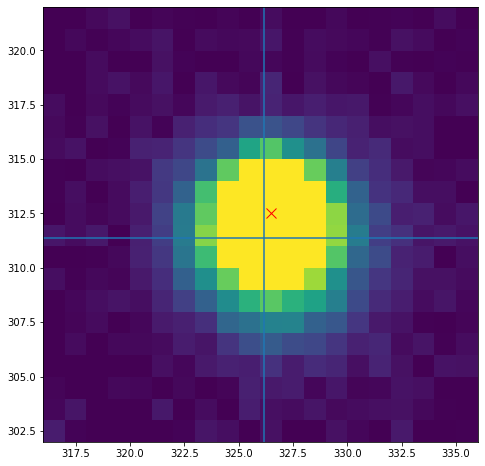

In [45]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(im,origin='lower',extent=[316,336,302,322],vmin=0,vmax=5000)
ax.plot(326.5,312.5,'rx',ms=10)
ax.axvline(x_com)
ax.axhline(y_com);

## Summary 

It is hard to actually overstate how useful `meshgrid` can be in certain situations. Anytime we want to evaluate something across a grid of locations, essentially, we can probably use meshgrid to make it happen quickly and efficiently. 

Hope this was useful!